<a href="https://colab.research.google.com/github/adamgrzanek/CV_damaged_car_detection/blob/main/predictions_with_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Przygotowanie (importy bibliotek i modeli)

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import imutils
import pickle
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from matplotlib import cm

In [2]:
pip install tf-keras-vis tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 548.6 kB/s eta 0:00:00


In [3]:
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam

## Pobieranie modelu z huggingface
https://huggingface.co/AdamGie/CV_damaged_car_detection/tree/main

In [4]:
!git lfs install
!git clone https://huggingface.co/AdamGie/CV_damaged_car_detection

Git LFS initialized.
Cloning into 'CV_damaged_car_detection'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (12/12), 3.70 KiB | 947.00 KiB/s, done.


## Pobranie detektora YOLO

In [5]:
%%bash
git clone https://github.com/pjreddie/darknet.git
wget -q https://pjreddie.com/media/files/yolov3.weights
mkdir images

Cloning into 'darknet'...


In [6]:
yolo_labels_path = '/content/darknet/data/coco.names'
yolo_config_path = '/content/darknet/cfg/yolov3.cfg'
yolo_weights_path = '/content/yolov3.weights'

## Pobranie modelu do segmentacji (SAM segment anything model)
https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

In [7]:
pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-90jimzd3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-90jimzd3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=e77365b74e650b5c77cfed9714c723cd773c6d7866696dfc8518848e820c8c3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-y6h35q4d/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [8]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-03-12 23:46:18--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.51, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  88.5MB/s    in 20s     

2024-03-12 23:46:38 (123 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [9]:
import torch
import torchvision
from segment_anything import sam_model_registry, SamPredictor

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True


## Funkcje

In [10]:
def segment_car(img, box, margin=0):
    '''
    Funkcja do segmentacji obiektu w ramce.
    Parametrem jest zdjęcie i ramka. Opcjonalnie można dodać margines do powiększenia/zmniejszenia ramki
    Funkcja zwraca maske o wymiarach zdjęcia i wartościach True i False.
    '''
    try:
        image = cv2.imread(img)
    except:
        image = img

    predictor.set_image(image)

    if margin:
        box = [box[0]-margin, box[1]-margin, box[2]+margin, box[3]+margin]

    input_box = np.array(box) # box z funkcji get_car_image

    masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
    )

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.title('Wykryty obiekt')
    plt.show()

    return masks[0]

In [11]:
def find_min_max(x):
    '''
    Funkcja do zwracania pozycji pierwszego i ostatniego niezerowego elementu w objekcie iterowalnym.
    (Do znalezienie konturów na masce obrazu)
    przykład: X = [0, 0, 4, 8, 2, 6, 0, 0]
    find_min_max(X) -> 2, 6
    '''

    for i in range(len(x)):
        if x[i] > 0:
            min = i
            break
    for j in range(len(x)):
        if x[-j] != 0:
            max = len(x) - j
            break
    return min, max

In [12]:
def clean_image(img, mask):
    '''
    Funkcja do nałożenia maski (o wartościach True/False) na obraz oraz wykadrowania danego objektu.
    Wynikiem jest wyfiltrowany i wykadrowany objekt na białym tle
    '''
    try:
        new_image = cv2.imread(img)
    except:
        new_image = img

    # nałożenie maski
    for h in range(mask.shape[0]):
        for w in range(mask.shape[1]):
            if mask[h][w] == False:
                new_image[h][w] = [255, 255, 255] # białe tło
                #new_image[h][w] = [255, 0, 255] #  różowe tło (rzadki kolor na elementy pojazdu; czasem róznice w predykcji pomiędzy białym a różowym tłem)

    # szukanie skrajnych punktów (na masce o wartościach 0 i 1)
    mask_int = mask.astype(int)
    vertical_search = np.sum(mask_int, axis=0) # szuka w poziomie (punkt lewy/prawy)
    horizontal_search = np.sum(mask_int, axis=1) # szuka w pionie (punkt górny/dolny)

    left, right = find_min_max(vertical_search)
    top, bottom = find_min_max(horizontal_search)

    cutted_image = new_image[top:bottom, left:right]
    cv2_imshow(cutted_image)

    return cutted_image

In [13]:
# yolo_labels_path = '/content/darknet/data/coco.names'
# yolo_config_path = '/content/darknet/cfg/yolov3.cfg'
# yolo_weights_path = '/content/yolov3.weights'

def get_car_image(image_path,
                  weights_path= yolo_weights_path,
                  config_path = yolo_config_path,
                  labels = yolo_labels_path,
                  CONFIDENCE = 0.6, THRESHOLD = 0.3, margin=20, show_data=True):
    '''
    Funkcja do detekcji obiektów (pojazdów).
    Argumentem jest ścieżka do zdjęcia.
    Na wyjściu otrzymamy obraz z wykrytymi pojazdami oraz wykadrowany główny pojazd (z ramką do segmantacji)
    '''
    LABELS = open(labels).read().strip().split('\n')
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype='uint8')

    net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

    image = cv2.imread(image_path)

    (h, w) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1/255., (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(ln)


    boxes = []
    confidences = []
    class_ids = []
    cars = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > CONFIDENCE:
                box = detection[0:4] * np.array([w, h, w, h])
                (x_center, y_center, width, height) = box.astype('int')

                x = int(x_center - (width / 2))
                y = int(y_center - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)


    image_copy = image.copy()
    image_with_boxes = image.copy()
    if len(idxs) > 0:
        for n, i in enumerate(idxs.flatten(), start=1):

            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[class_ids[i]]]
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, 2) # original box

            text = f'{LABELS[class_ids[i]]}: {confidences[i]:.4f}    number: {n}'
            cv2.putText(image_with_boxes, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            if LABELS[class_ids[i]] == 'car' or LABELS[class_ids[i]] == 'truck' :
                area = w * h
                cars.append({'confidence': confidences[i], 'area': area, 'x': x, 'y': y, 'w': w, 'h': h})

        cv2_imshow(image_with_boxes)


    if cars: # jeśli znalanł pojazdy
        main_car = sorted(cars, key=lambda x: x['area'], reverse=True)[0] # kolejność po największym obszarze
        x, y, w, h = main_car['x'], main_car['y'], main_car['w'], main_car['h'] # original box

        # powiększony box
        margin = margin
        y_start = y - margin if y - margin >= 0 else 0 # np.clip
        y_end = y + h + margin if y + h + margin <= image.shape[0] else image.shape[0]
        x_start = x - margin if x - margin >= 0 else 0
        x_end = x + w + margin if x + w + margin <= image.shape[1] else image.shape[1]

        expanded_box = [x_start, y_start, x_end, y_end]
        main_car_image = image_copy[y_start : y_end, x_start : x_end]

    image = imutils.resize(image, width=600) # zmiana rozmiaru z zachowaniem proporcji
    if show_data:
        print('\nOryginalne zdjęcie po ustandaryzowaniu rozmiaru')
        cv2_imshow(image)

    if cars:
        main_car_image_resized = imutils.resize(main_car_image, width=600)
        if show_data:
            print('\nPojazd do klasyfikacji')
            cv2_imshow(main_car_image_resized)
        return main_car_image, expanded_box

In [14]:
def prepare_image(img, input_shape=(224, 224, 3)):
    '''
    Funkcja do przygotowania zdjęcia do klasyfikacji
    '''
    try:
        image = cv2.imread(img)
    except:
        image = img
    image = cv2.resize(image, (input_shape[0], input_shape[1]))
    image = image.astype('float') / 255.
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    return image

In [15]:
def model_modifier(mdl):
    '''
    Funkcja do zmiany funkcji atywacji (na liniową) w ostatniej warstwie modelu
    '''
    mdl.layers[-1].activation = tf.keras.activations.linear

In [16]:
def show_heatmap(img, model, labels_path):
    '''
    Funkcja do pokazania mapy ciepła - miejsc decyzyjnych dla modelu
    '''

    # przygotowane zdjęcia
    image = prepare_image(img)

    # predykcja
    y_pred = model.predict(image)[0]

    # wczytanie etykiet
    with open(labels_path, 'rb') as file:
        classes = pickle.loads(file.read()) # {'damaged_cars': 0, 'ok_cars': 1}

    labels = dict(enumerate(classes)) # {0: 'damaged_cars', 1: 'ok_cars'}


    pred_class = np.argmax(y_pred)
    text = f'{labels[pred_class]}, prob: {100 * y_pred[pred_class]:.2f}%'



    # {'damaged_cars': 0, 'ok_cars': 1}
    score = CategoricalScore(pred_class)
    input_class = 'ok_car' if pred_class == 1 else 'damaged_car'


    gradcam = Gradcam(model,
                      model_modifier=model_modifier, # zmienia funkcję aktywacji w ostatniej warstwie modelu
                      clone=False)

    # Generowanie heatmapy z GradCAM
    cam = gradcam(score,
                image,
                penultimate_layer=-1)


    # obraz
    fig, ax = plt.subplots()
    heatmap = np.uint8(cm.jet(cam[0])[..., :4] * 255)
    ax.set_title(text, fontsize=16)
    ax.imshow(image[0])
    ax.imshow(heatmap, cmap='jet', alpha=0.5) # nakładka
    ax.axis('off')
    plt.show()

    print(text)

In [17]:
# funkcje SAM

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

## Wczytanie modelu i etykiet

In [18]:
labels = '/content/CV_damaged_car_detection/labels_2_classes.pickle'

loaded_model = load_model('/content/CV_damaged_car_detection/model_custom_VGG16_2_classes.hdf5')
loaded_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [19]:
INPUT_SHAPE = (224, 224, 3)

# Predykcja

Wczytaj swoje zdjęcia do katalogu "images"

In [30]:
img_path = 'images/d10.jpg'

## Wykonanie etapami

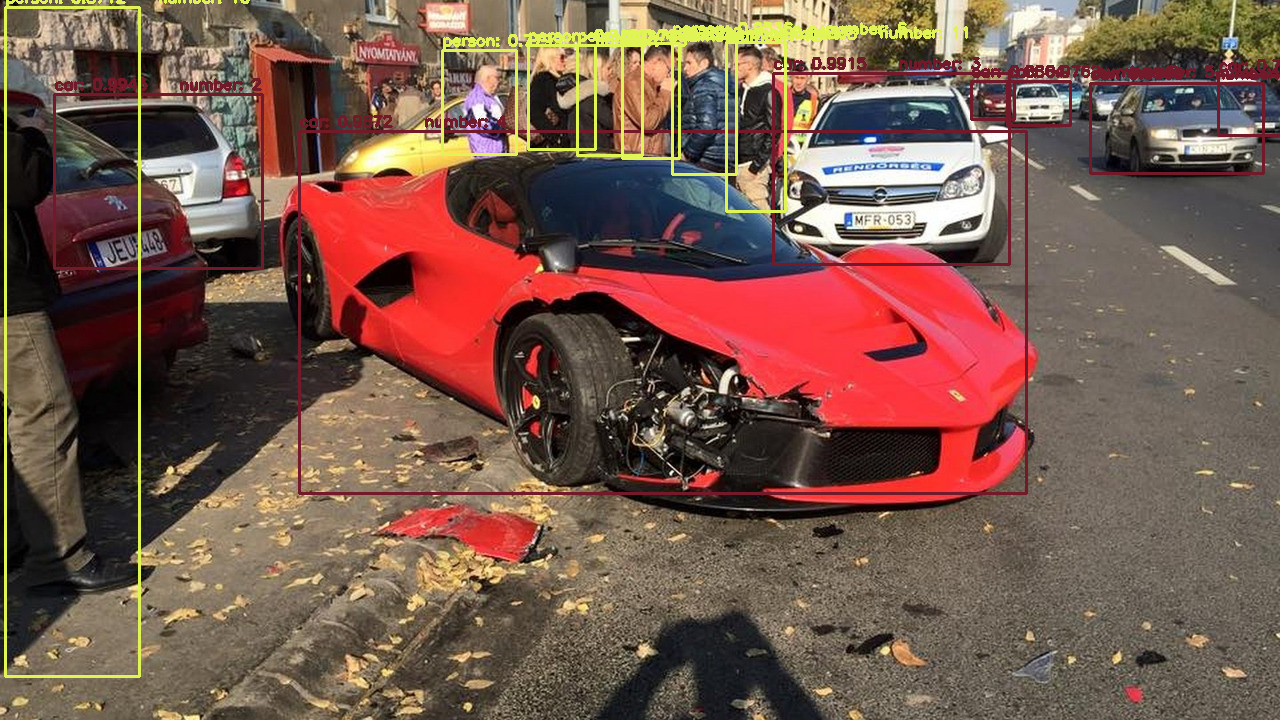


Oryginalne zdjęcie po ustandaryzowaniu rozmiaru


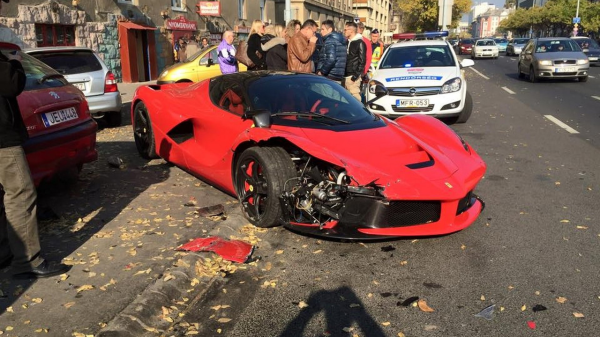


Pojazd do klasyfikacji


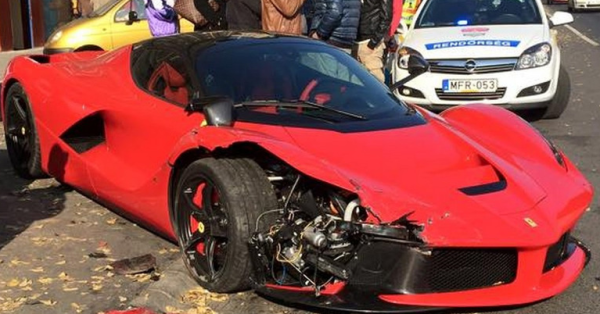

In [31]:
# Detekcja obiektów i wyznaczenie ramki na główym pojeździe
main_car_image, expanded_box = get_car_image(img_path, show_data=True)

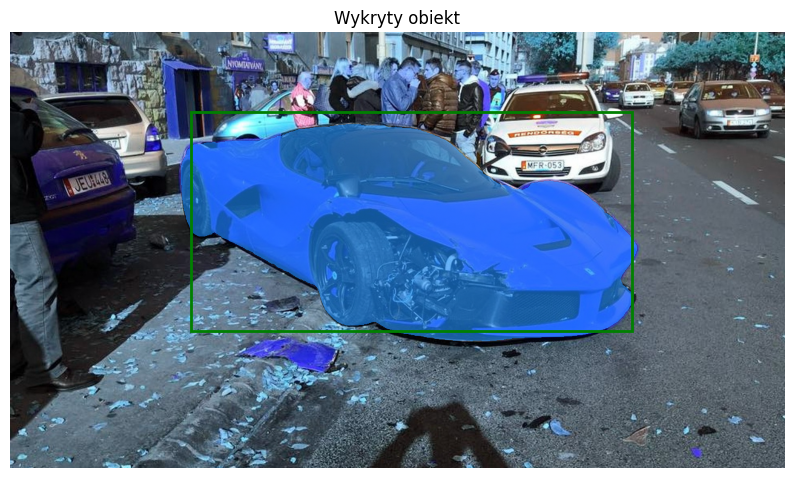

In [32]:
# Segmentacja wybranego obiektu i wydobycie maski
mask = segment_car(img_path, expanded_box, margin=-20) # gdy pojazd nie jest zasegmentowany odpowiednio spróbój zmienić "margin" (zmniejszyć/zwiększyć oryginalną ramkę)

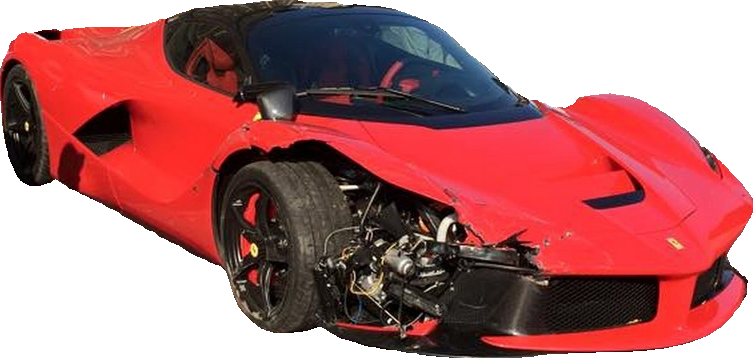

In [33]:
# Czyszczenie obrazu
clean_car = clean_image(img_path, mask)

1/1 [==============================] - 0s 19ms/step


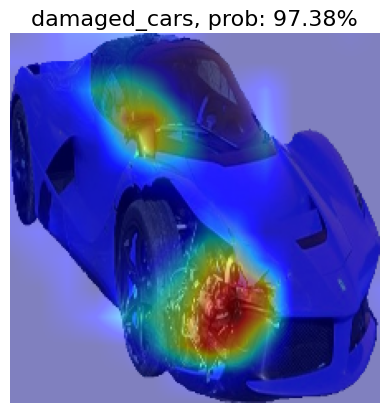

damaged_cars, prob: 97.38%


In [34]:
# Predykcja i mapa ciepła
show_heatmap(clean_car, loaded_model, labels)

1/1 [==============================] - 0s 28ms/step


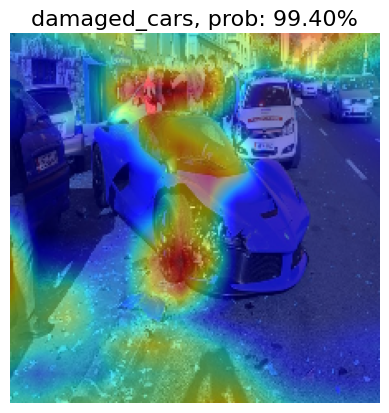

damaged_cars, prob: 99.40%


In [35]:
# Predykcja i mapa ciepła oryginalnego obrazu
show_heatmap(img_path, loaded_model, labels)

## Wykonanie zbiorcze

Detekcja obiektów i wyznaczenie ramki na główym pojeździe


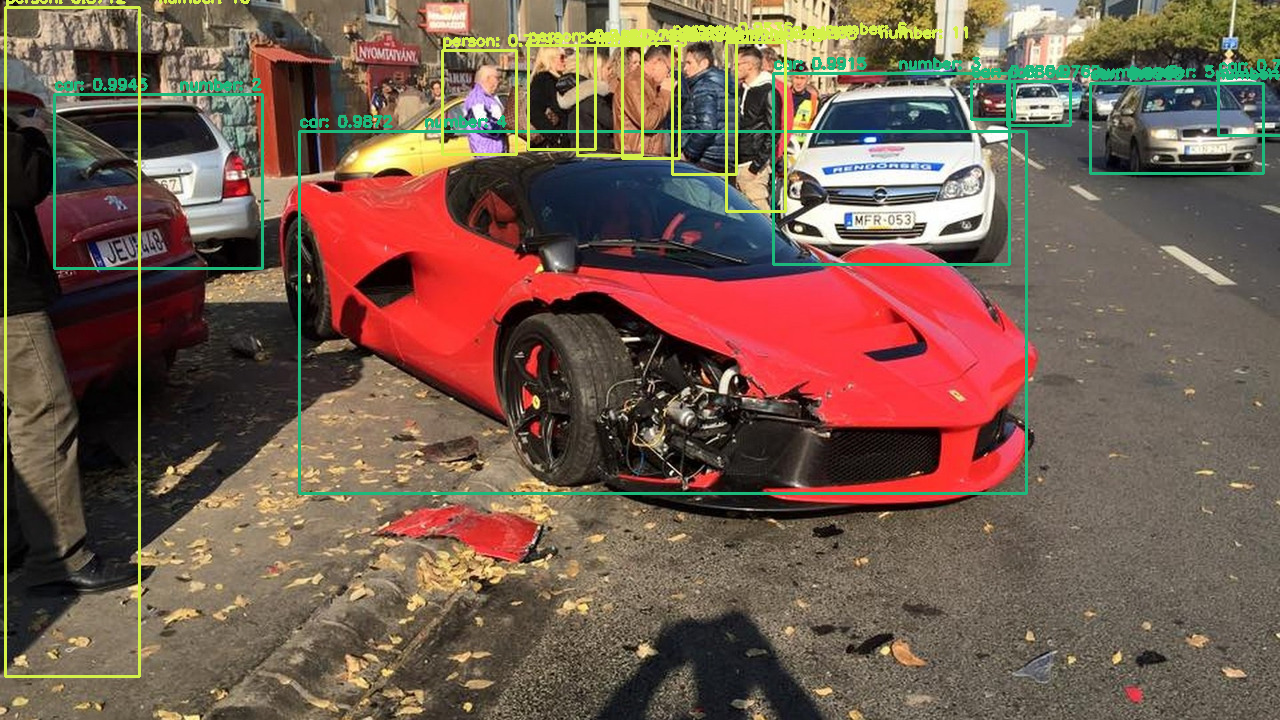


Oryginalne zdjęcie po ustandaryzowaniu rozmiaru


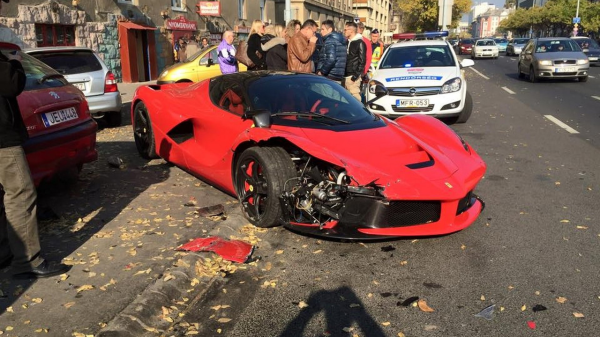


Pojazd do klasyfikacji


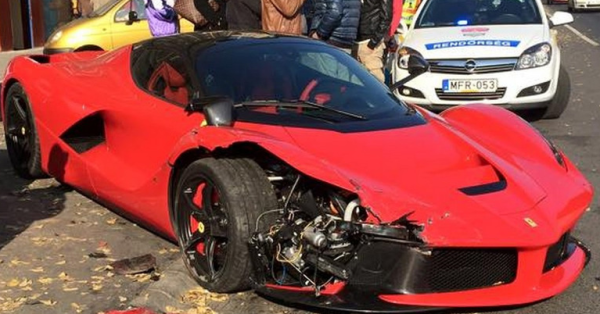


Segmentacja wybranego obiektu i wydobycie maski


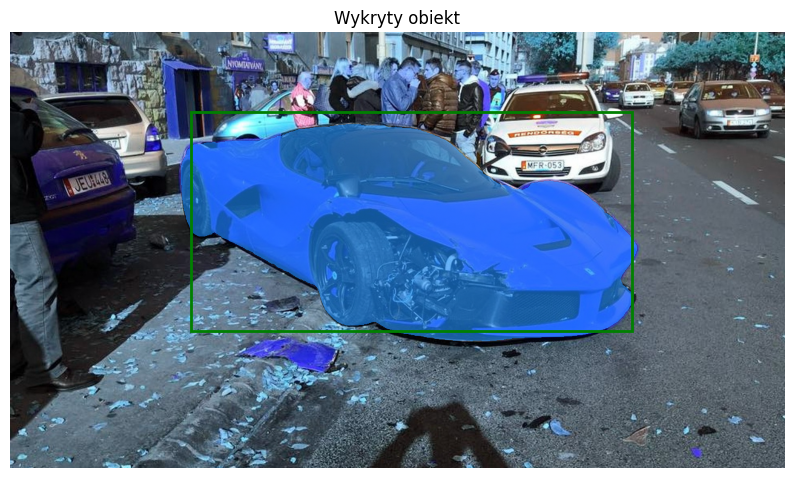


Czyszczenie obrazu


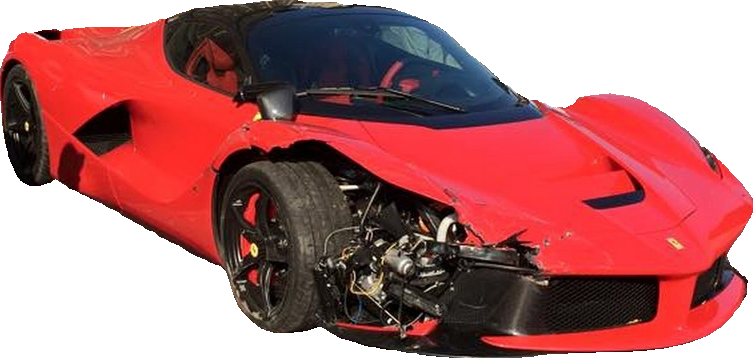


Predykcja i mapa ciepła
1/1 [==============================] - 0s 35ms/step


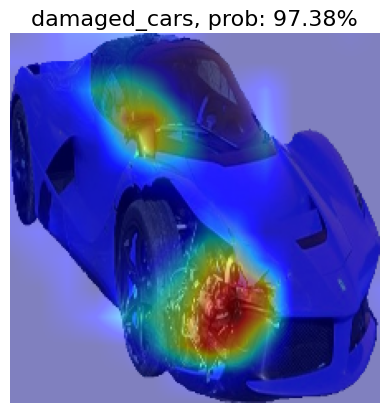

damaged_cars, prob: 97.38%


In [36]:
print('Detekcja obiektów i wyznaczenie ramki na główym pojeździe')
main_car_image, expanded_box = get_car_image(img_path, show_data=True)

print('\nSegmentacja wybranego obiektu i wydobycie maski')
mask = segment_car(img_path, expanded_box, margin=-20)

print('\nCzyszczenie obrazu')
clean_car = clean_image(img_path, mask)

print('\nPredykcja i mapa ciepła')
show_heatmap(clean_car, loaded_model, labels)